# Permutations-stats demo
Get some tools

In [1]:
from collections import Counter, namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import time

In [45]:
from rpy2 import robjects
from rpy2.robjects import numpy2ri
numpy2ri.activate()
robjects.r("library('brunnermunzel')")
robjects.r("library('exactRankTests')")

bmp = robjects.r("brunnermunzel.permutation.test")
wilcox = robjects.r("wilcox.exact")

R[write to console]:  Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.


R[write to console]: 
Attaching package: ‘exactRankTests’


R[write to console]: The following objects are masked from ‘package:coin’:

    dperm, pperm, qperm, rperm




In [2]:
def describe(array):
    """Prints mean, std, median, iqr, range of a 1d array"""
    mean = np.mean(array)
    std = np.std(array)
    median = np.median(array)
    p25 = np.percentile(array, 25)
    p75 = np.percentile(array, 75)
    min_ = np.min(array)
    max_ = np.max(array)
    print(f"{len(array)} items with: \n"
          f"Mean: {mean:.2f}\tstd: {std:.2f}\n"
          f"Median: {median}\tIQR: [{p25:.1f}-{p75:.1f}]\tRange: [{min_}-{max_}]")


def print_results(res_tuple, test=None, permutations=None):
    if test is None:
        test = res_tuple.test
    if permutations is None:
        permutations = res_tuple.permutations

    print(f"{test} Statistic: {res_tuple.statistic:.3f}\t"
          f"p-value: {res_tuple.pvalue:.4e}\t# permutations computed: {permutations}")


def timeit(func, *args, **kwargs):
    start_time = time.time()
    vals = func(*args, **kwargs)
    end_time = time.time()
    print(f"Run time: {end_time - start_time:.3f}s")
    return vals

## We'll need data
Lets load some classic data.
This data was generated with the following cell, which you can skip if you
don't have scikit-learn installed. You have the files.

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_data = iris["data"]
iris_target= iris["target"]

pd.DataFrame(iris_data).to_csv("iris_data.csv", index=False)
pd.DataFrame(iris_target).to_csv("iris_target.csv", index=False)

In [4]:
iris_data = pd.read_csv("iris_data.csv").to_numpy()
iris_target = pd.read_csv("iris_target.csv").to_numpy().squeeze()
iris_data[45:55]

array([[4.8, 3. , 1.4, 0.3],
       [5.1, 3.8, 1.6, 0.2],
       [4.6, 3.2, 1.4, 0.2],
       [5.3, 3.7, 1.5, 0.2],
       [5. , 3.3, 1.4, 0.2],
       [7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.3, 4. , 1.3],
       [6.5, 2.8, 4.6, 1.5]])

In [5]:
iris_target[45:55]


array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [6]:
target_counts = Counter(iris_target)
target_counts  # There are 50 items for each of the 3 groups


Counter({0: 50, 1: 50, 2: 50})

Let's take the first 12 of the first and second kind of flowers

In [7]:
zero = iris_data[:9]
one = iris_data[50:59]

And of them the first variable

In [8]:
zero_1 = zero[:,0]
one_1 = one[:, 0]

Let's get some description and plot that

ZERO:	9 items with: 
Mean: 4.86	std: 0.29
Median: 4.9	IQR: [4.6-5.0]	Range: [4.4-5.4]

ONE:	9 items with: 
Mean: 6.20	std: 0.65
Median: 6.4	IQR: [5.7-6.6]	Range: [4.9-7.0]


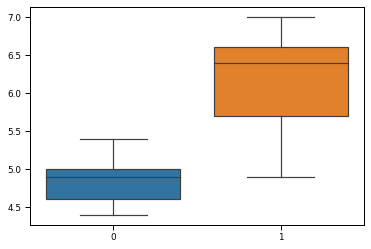

In [9]:
print("ZERO:\t", end="")
describe(zero_1)
print("\nONE:\t", end="")
describe(one_1)

with sns.plotting_context('paper'):
    sns.boxplot(np.concatenate([iris_target[:9], iris_target[50:59]]),
                np.concatenate([zero_1, one_1]))

Now let's import permutations-stats

In [10]:
import permutations_stats.permutations as pm

A test is run with: (by default, an exact Brunner Munzel test)
```python
pm.permutation_test(x, y)
```
which returns a named tuple

In [11]:
pm.permutation_test(zero_1, one_1)

PermutationsResults(statistic=7.589466384404109, pvalue=0.0006993006993006993, permutations=48620, test='brunner_munzel', alternative='TWO_SIDED', method='exact')

The returned values are:
- The Brunner Munzel statistic of the provided data
- The proportion of permutations where that statistic was at least as extreme as that statistic (7.589), i.e. the pvalue
- The number of permutations calculated (all combinations as order does not matter). 48 620
- The name of the test run
- The alternative hypothesis
- The method: exact or simulation

and with the `print_results` function defined above:

In [12]:
res = pm.permutation_test(zero_1, one_1)
print_results(res)

brunner_munzel Statistic: 7.589	p-value: 6.9930e-04	# permutations computed: 48620


In [13]:
# and slightly modified here to include timing (without compilation that happens only once)
res = timeit(pm.permutation_test, zero_1, one_1)
print_results(res)

Run time: 0.588s
brunner_munzel Statistic: 7.589	p-value: 6.9930e-04	# permutations computed: 48620


If we need exact pvalue for 9 and 14 elements, that makes a lot more combinations:

ZERO:	9 items with: 
Mean: 4.86	std: 0.29
Median: 4.9	IQR: [4.6-5.0]	Range: [4.4-5.4]

ONE bis:	14 items with: 
Mean: 6.00	std: 0.65
Median: 6.05	IQR: [5.5-6.5]	Range: [4.9-7.0]


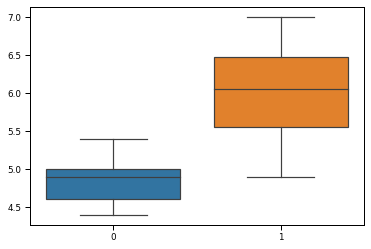

In [14]:
print("ZERO:\t", end="")
describe(zero_1)
print("\nONE bis:\t", end="")
one_bis = iris_data[50:64]
one_bis_1 = one_bis[:, 0]
describe(one_bis_1)
with sns.plotting_context('paper'):
    sns.boxplot(np.concatenate([iris_target[:9], iris_target[50:64]]),
                np.concatenate([zero_1, one_bis_1]))

In [15]:
res = timeit(pm.permutation_test, zero_1, one_bis_1)
print_results(res)

Run time: 10.444s
brunner_munzel Statistic: 8.846	p-value: 1.2604e-04	# permutations computed: 817190


### Simulations
If you'd be happy with 100 000 simulations, you can run
```python
pm.permutation_test(x, y, method="simulation", n_iter=100_000)
```

In [16]:
res = timeit(
    pm.permutation_test, zero_1, one_bis_1, method="simulation", n_iter=100_000)
print_results(res)

Run time: 2.279s
brunner_munzel Statistic: 8.846	p-value: 1.5000e-04	# permutations computed: 100001


If you need reproducible results, you can set a seed and run
```python
pm.permutation_test(x, y, method="simulation", seed=50)
```

In [17]:
res = pm.permutation_test(zero_1, one_bis_1, method="simulation", n_iter=100_000, seed=50)
print_results(res)

res= pm.permutation_test(zero_1, one_bis_1, method="simulation", n_iter=100_000, seed=50)
print_results(res)

brunner_munzel Statistic: 8.846	p-value: 1.3000e-04	# permutations computed: 100001
brunner_munzel Statistic: 8.846	p-value: 1.3000e-04	# permutations computed: 100001


You can use the Mann-Whitney test like this:
```python
pm.permutation_test(x, y, test="mann_whitney")
```

In [18]:
res = pm.permutation_test(zero_1, one_bis_1, test="mann_whitney")
print_results(res)

mann_whitney Statistic: 117.500	p-value: 1.6520e-04	# permutations computed: 817190


### Alternatives
Alternatives are "greater", less" or (default) "two-sided"

In [19]:
res = pm.permutation_test(zero_1, one_bis_1, test="mann_whitney", method="simulation", alternative="less")
print_results(res)

mann_whitney Statistic: 8.500	p-value: 9.9990e-05	# permutations computed: 10001


In [20]:
res = pm.permutation_test(zero_1, one_bis_1, test="mann_whitney", method="simulation", alternative="greater")
print_results(res)

mann_whitney Statistic: 8.500	p-value: 9.9990e-01	# permutations computed: 10001


Compare with scipy

In [21]:
import scipy.stats

In [22]:
joined = np.stack([zero_1, one_bis_1[:9]], axis=1)

Scipy implements an exact wilcoxon test for up to 25 observations without ties

In [23]:
res = pm.repeated_permutation_test(joined, test="wilcoxon", alternative="greater")
print_results(res)
res = scipy.stats.wilcoxon(zero_1, one_bis_1[:9], alternative="greater", mode="exact")
print_results(res, "Wilcoxon (scipy)", 0)

wilcoxon Statistic: -43.000	p-value: 9.9805e-01	# permutations computed: 512
Wilcoxon (scipy) Statistic: 1.000	p-value: 9.9805e-01	# permutations computed: 0


In [24]:
res = pm.repeated_permutation_test(joined, test="wilcoxon",  alternative="less")
print_results(res)
res = scipy.stats.wilcoxon(zero_1, one_bis_1[:9], alternative="less", mode="exact")
print_results(res, "Wilcoxon (scipy)", 0)

wilcoxon Statistic: -43.000	p-value: 3.9062e-03	# permutations computed: 512
Wilcoxon (scipy) Statistic: 1.000	p-value: 3.9062e-03	# permutations computed: 0


In [25]:
res = pm.repeated_permutation_test(joined, test="wilcoxon", alternative="two-sided")
print_results(res)
res = scipy.stats.wilcoxon(zero_1, one_bis_1[:9], alternative="two-sided", mode="exact")
print_results(res, "Wilcoxon (scipy)", 0)

wilcoxon Statistic: 43.000	p-value: 7.8125e-03	# permutations computed: 512
Wilcoxon (scipy) Statistic: 1.000	p-value: 7.8125e-03	# permutations computed: 0


If you need the same statistic used in scipy, you can set return_w to 2

In [26]:
from permutations_stats.tests import wilcoxon
wilcoxon.test(joined, return_w=2)

1.0

And to 1 for R's equivalent

In [27]:
wilcoxon.test(joined, 1)

1.0

In [59]:
r_result = namedtuple("R_result", ("statistic", "pvalue", "test"))


For Mann-Whitney-Wilcoxon, we can compare the statistics, but the pvalue of `scipy` is not reliable with few observations (see the test doc page).
We can also compare with `wilcox.exact` from R package `exactRankTests` as `coin` doesn't seem to work in rpy2


In [67]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, test="mann_whitney", alternative="greater"), "Mann-Whitney (perm-s)")
print_results(
    scipy.stats.mannwhitneyu(zero_1, one_bis_1, alternative="greater"), "Mann-Whitney (scipy)", 0)
r_data = wilcox(zero_1, one_bis_1, alternative="greater", exact=True)
print_results(
    r_result(r_data[0][0], r_data[2][0], "Mann-Whitney (R)"), permutations="?")

Mann-Whitney (perm-s) Statistic: 8.500	p-value: 9.9993e-01	# permutations computed: 817190
Mann-Whitney (scipy) Statistic: 8.500	p-value: 9.9974e-01	# permutations computed: 0
Mann-Whitney (R) Statistic: 8.500	p-value: 9.9993e-01	# permutations computed: ?


In [68]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, test="mann_whitney", alternative="less"), "Mann-Whitney (perm-s)")
print_results(
    scipy.stats.mannwhitneyu(zero_1, one_bis_1, alternative="less"), "Mann-Whitney (scipy)", 0)
r_data = wilcox(zero_1, one_bis_1, alternative="less", exact=True)
print_results(
    r_result(r_data[0][0], r_data[2][0], "Mann-Whitney (R)"), permutations="?")

Mann-Whitney (perm-s) Statistic: 8.500	p-value: 8.4436e-05	# permutations computed: 817190
Mann-Whitney (scipy) Statistic: 8.500	p-value: 3.2873e-04	# permutations computed: 0
Mann-Whitney (R) Statistic: 8.500	p-value: 8.4436e-05	# permutations computed: ?


In [71]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, test="mann_whitney", alternative="two-sided"), "Mann-Whitney (perm-s)")
print_results(
    scipy.stats.mannwhitneyu(zero_1, one_bis_1, alternative="two-sided"), "Mann-Whitney (scipy)", 0)
r_data = wilcox(zero_1, one_bis_1, alternative="two.sided", exact=True)
print_results(
    r_result(r_data[0][0], r_data[2][0], "Mann-Whitney (R)"), permutations="?")

Mann-Whitney (perm-s) Statistic: 117.500	p-value: 1.6520e-04	# permutations computed: 817190
Mann-Whitney (scipy) Statistic: 8.500	p-value: 6.5745e-04	# permutations computed: 0
Mann-Whitney (R) Statistic: 8.500	p-value: 1.6520e-04	# permutations computed: ?


For Brunner-Munzel, we can compare the statistic, but the pvalue of `scipy` is
not reliable with few observations (see
[the test doc page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.brunnermunzel.html)).  
We can also compare with brunnermunzel.permutation.test from R

In [77]:
print(r_data)


	permuted Brunner-Munzel Test

data:  structure(c(5.1, 4.9, 4.7, 4.6, 5, 5.4, 4.6, 5, 4.4), .Dim = 9L) and structure(c(7, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5, structure(c(5.1, 4.9, 4.7, 4.6, 5, 5.4, 4.6, 5, 4.4), .Dim = 9L) and 5.9, 6, 6.1), .Dim = 14L)
p-value = 6.363e-05
sample estimates:
P(X<Y)+.5*P(X=Y) 
       0.9325397 




In [79]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, alternative="less"))
print_results(
    scipy.stats.brunnermunzel(zero_1, one_bis_1, alternative="less"), "Brunner-Munzel (scipy)", 0)
r_data = bmp(zero_1, one_bis_1, alternative="less")
print_results(
    r_result(0, r_data[2][0], "Brunner-Munzel (R)"), permutations="?")

brunner_munzel Statistic: 8.846	p-value: 9.9994e-01	# permutations computed: 817190
Brunner-Munzel (scipy) Statistic: 8.846	p-value: 1.0701e-08	# permutations computed: 0
Brunner-Munzel (R) Statistic: 0.000	p-value: 6.3633e-05	# permutations computed: ?


In [80]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, alternative="greater"))
print_results(
    scipy.stats.brunnermunzel(zero_1, one_bis_1, alternative="greater"), "Brunner-Munzel (scipy)", 0)
r_data = bmp(zero_1, one_bis_1, alternative="greater")
print_results(
    r_result(0, r_data[2][0], "Brunner-Munzel (R)"), permutations="?")

brunner_munzel Statistic: 8.846	p-value: 6.7304e-05	# permutations computed: 817190
Brunner-Munzel (scipy) Statistic: 8.846	p-value: 1.0000e+00	# permutations computed: 0
Brunner-Munzel (R) Statistic: 0.000	p-value: 9.9994e-01	# permutations computed: ?


In [81]:
print_results(
    pm.permutation_test(zero_1, one_bis_1, alternative="two-sided"))
print_results(
    scipy.stats.brunnermunzel(zero_1, one_bis_1, alternative="two-sided"), "Brunner-Munzel (scipy)", 0)
r_data = bmp(zero_1, one_bis_1, alternative="two.sided")
print_results(
    r_result(0, r_data[2][0], "Brunner-Munzel (R)"), permutations="?")

brunner_munzel Statistic: 8.846	p-value: 1.2604e-04	# permutations computed: 817190
Brunner-Munzel (scipy) Statistic: 8.846	p-value: 2.1401e-08	# permutations computed: 0
Brunner-Munzel (R) Statistic: 0.000	p-value: 1.2237e-04	# permutations computed: ?
